In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('../')
from retinanet import coco_eval
from retinanet import csv_eval
from retinanet import model
from retinanet import paps_eval
from retinanet import paps_train
from retinanet.nms import get_nmsbox

# from retinanet import retina
from retinanet.dataloader import *
from retinanet.anchors import Anchors
from retinanet.losses import *
from retinanet.scheduler import *
from retinanet.hourglass import hg1, hg2, hg8
from retinanet.parallel import DataParallelModel, DataParallelCriterion

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam, lr_scheduler
import torch.optim as optim

# python train_paps.py --start_epoch 0 --end_epoch 120 --batch_size 24 \
#                     --saved_dir $OUT_MODEL_DIR --gpu_num 0 --num_workers 12 \
#                     --target_threshold 7 --topk 20 --filter_option 1  | 2>&1 | tee $log


In [2]:
# device = torch.device('cpu')
# device = torch.device('cuda')
GPU_NUM = 5 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
model = hg2(device, pretrained=True, progress=False, num_classes=2)
model.to(device)

num_classes 2
num_anchors per feature map 1


HourglassNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
  )
  (layer2): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

In [3]:
# model

In [3]:
criterion = PapsLoss(device, target_threshold=0.8, topk=10, filter_option=5)
criterion = criterion.to(device)
model.training = True

# https://gaussian37.github.io/dl-pytorch-lr_scheduler/
optimizer = optim.Adam(model.parameters(), lr = 1e-8)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=20, T_mult=2, eta_max=0.0008,  T_up=5, gamma=0.5)
# CosineAnnealingWarmRestarts

In [4]:
saved_dir = '../trained_models/HourGlass/loss_filter5' + '/'
e_epoch = 120
if os.path.isfile(saved_dir + 'epoch_' + str(e_epoch) +'_model.pt') :
    print('pretrainind file loading')
    state = torch.load(saved_dir + 'epoch_' + str(e_epoch) +'_model.pt')
    epoch = state['epoch']
    model.load_state_dict(state['state_dict'], strict=False)
    optimizer.load_state_dict(state['optimizer'])
    last_loss = state['loss']

pretrainind file loading


In [ ]:
# state = {
#     'epoch': 0,
#     'state_dict': model.state_dict(),
#     'optimizer': optimizer.state_dict(),
#     'loss' : 0.6
# }
# torch.save(state, saved_dir + 'model.pt')

In [5]:
dataset_val = PapsDataset('../data/', set_name='val_2class',
                            transform=val_transforms)

val_data_loader = DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [6]:
paps_eval.evaluate_paps(dataset=dataset_val, 
  dataloader=val_data_loader, 
  model=model, 
  saved_dir=saved_dir, 
  device = device,
  threshold=0.1) 


100%|██████████| 3739/3739 [03:38<00:00, 17.13it/s]


GT_results 17716
pred_results 27425
validation time : 219.01200366020203
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
******************total*********************
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.72s).
Accumulating evaluation results...
DONE (t=0.47s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.045
 Average Recall     (AR) @[ 

In [7]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White
import cv2
import matplotlib.pyplot as plt

def visualize_bbox(img, bbox, cla, color=BOX_COLOR, thickness=1):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = list(map(int, bbox))
#     x_min, y_min, x_max, y_max = list(map(round, bbox))
    if int(cla) == 1 :
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=BOX_COLOR, thickness=thickness)
    else :
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(255,255,0), thickness=thickness)
    return img

def visualize(image, bboxes, classes):
    img = image.copy()
#     img = image.clone().detach()
    for bbox, cla in zip(bboxes, classes):
#         print(bbox)
        img = visualize_bbox(img, bbox, cla)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)

In [8]:
model.training = False

for index, data in enumerate(tqdm(val_data_loader)) :
    with torch.no_grad():        
        images, tbox, tlabel, targets = data
#         print(images[0].shape)
#         print('targets', targets)
        batch_size = len(images)

        c, h, w = images[0].shape
        images = torch.cat(images).view(-1, c, h, w).to(device)

        outputs = model(images)
        scores, labels, boxes = (outputs)
#         print('scores', scores)
#         print(labels)
#         print(boxes)

        scores = scores.cpu()
        labels = labels.cpu()
        boxes  = boxes.cpu()  

#         scores_list.append(scores)

        if boxes.shape[0] > 0:
            # change to (x, y, w, h) (MS COCO standard)
            boxes[:, 2] -= boxes[:, 0]
            boxes[:, 3] -= boxes[:, 1]
    if int(targets[0][0,4]) == 1 :
        print(targets)
        break

  0%|          | 2/3739 [00:01<42:15,  1.47it/s]

(tensor([[214.7500,  96.5000, 231.0000, 109.5000,   1.0000],
        [187.2500, 118.0000, 200.7500, 135.0000,   1.0000],
        [189.2500, 137.2500, 202.7500, 156.2500,   1.0000],
        [165.7500, 144.7500, 180.2500, 164.0000,   1.0000],
        [229.7500, 114.0000, 242.0000, 129.0000,   1.0000],
        [255.7500,  64.0000, 271.5000,  81.5000,   1.0000],
        [255.0000,  82.5000, 273.5000,  98.2500,   1.0000],
        [249.5000, 104.5000, 260.0000, 121.2500,   1.0000],
        [258.7500, 121.5000, 272.7500, 138.0000,   1.0000],
        [271.5000, 125.7500, 282.5000, 145.0000,   1.0000],
        [261.2500, 136.2500, 272.0000, 148.2500,   1.0000],
        [234.2500, 161.0000, 247.5000, 175.7500,   1.0000],
        [ 63.0000,  65.0000,  79.5000,  80.5000,   1.0000],
        [ 94.5000, 175.2500, 109.7500, 192.7500,   1.0000],
        [186.2500, 162.5000, 199.5000, 176.0000,   1.0000],
        [172.7500, 171.5000, 185.2500, 188.7500,   1.0000],
        [280.0000, 147.7500, 295.2500, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
torch.Size([320, 320, 3])


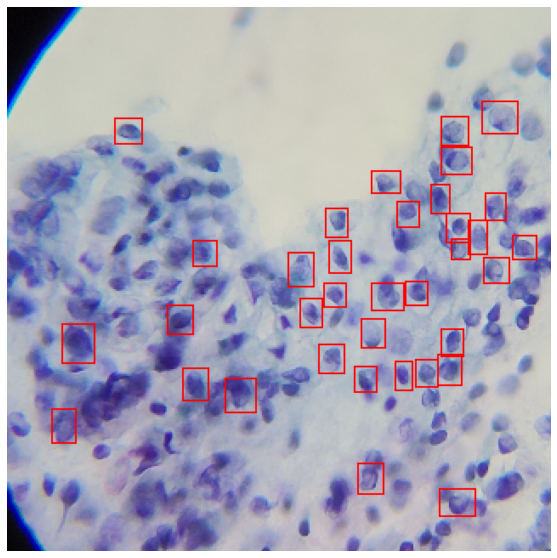

In [13]:
# image = image.cpu()
print(type(image))
image = images.squeeze()
image = torch.transpose(image, 0, 1)
image = torch.transpose(image, 1, 2)
print(image.shape)
visualize(image.cpu().numpy(), targets[0][:,:4], targets[0][:,4])

In [14]:

nboxes, nscores = get_nmsbox(boxes, scores, isCenter=True, iou_threshold=0.3)
# print((boxes))
for b in nboxes :
    b[2] += b[0]
    b[3] += b[1]
# boxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.1746, 0.1528, 0.1237, 0.0905, 0.0716, 0.0700, 0.0655, 0.0650, 0.0616,
        0.0589, 0.0565])
[tensor([ 52.4521, 212.5098,  83.6980, 243.2293]), tensor([ 28.6361, 180.8779,  58.9248, 211.3437]), tensor([ 28.7014, 156.8532,  59.3940, 187.3127]), tensor([ 68.7663, 276.3867,  98.9404, 307.2098]), tensor([116.7405, 212.7286, 147.1979, 243.1046]), tensor([ 20.9832, 228.8553,  50.7009, 259.7561]), tensor([108.3581, 260.0572, 140.0871, 292.3940]), tensor([  4.6556, 140.3597,  35.0657, 171.0298])]


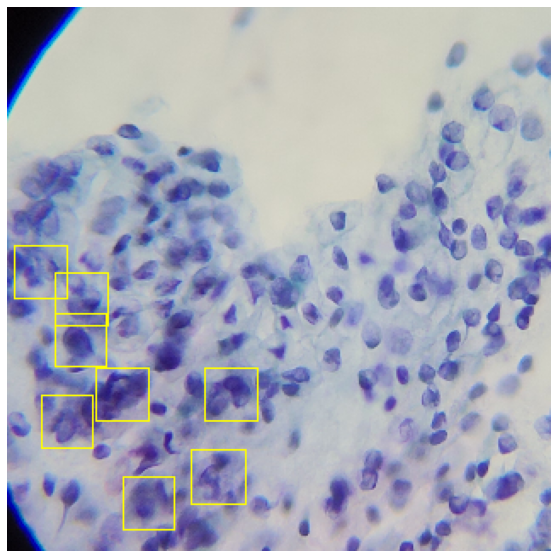

In [17]:
pred_box = []
for s,b in zip(nscores, nboxes) :
    if s > 0.05 :
        pred_box.append(b)
print(scores) 
print(pred_box)
visualize(image.cpu().numpy(), pred_box, labels)

In [18]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

# annType = 'bbox'

# cocoGt=COCO(saved_dir + 'val_2class_GTbbox_results.json')
# cocoDt=cocoGt.loadRes(saved_dir + 'val_2class_bbox_results.json')
coco_true = dataset_val.coco
coco_pred = coco_true.loadRes(saved_dir + '{}_bbox_results.json'.format(dataset_val.set_name))
coco_gt = coco_true.loadRes(saved_dir + '{}_GTbbox_results.json'.format(dataset_val.set_name))


# running evaluation
cocoEval = COCOeval(coco_gt,coco_pred,'bbox')
cocoEval.params.imgIds = 1
cocoEval.params.iouThrs = [.1]
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
DONE (t=0.35s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.10:0.10 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.10:0.10 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.10:0.10 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.10:0.10 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.10:0.10 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.10:0.10 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.10:0.10 | area=   all | m